In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    

In [3]:
state_1 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_1", index_col = 0)
state_2 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_2", index_col = 0)
state_3 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_3", index_col = 0)
state_4 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_4", index_col = 0)
state_5 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_5", index_col = 0)

In [4]:
df_wo = pd.concat([state_1,state_2,state_3,state_4,state_5])

In [5]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

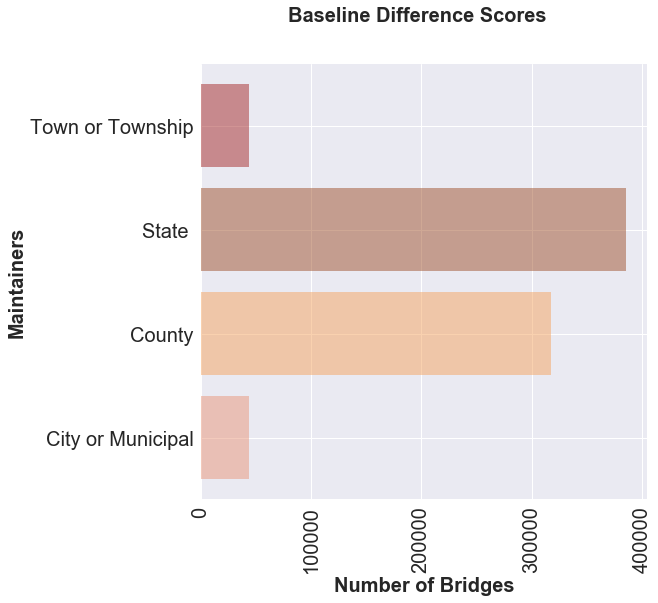

In [11]:
maintainers = df_anova[df_anova['maintainer'].isin([1,2,3,4])]
agency = {
         1 : "State Highway Agency",
         2 : "County Highway Agency",
         3 : "Town or Township Highway Agency",
         4 : "City or Municipal Highway Agency"
         }
maintainers['maintainername'] = maintainers['maintainer'].map(agency)


count_maint = maintainers.groupby('maintainername')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["City or Municipal", "County", "State ", "Town or Township"]
no_of_records = count_maint
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['darksalmon','sandybrown','sienna','brown'])
plt.xticks(size = 20, rotation = 90)
plt.yticks(size = 20)
plt.ylabel("Maintainers", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

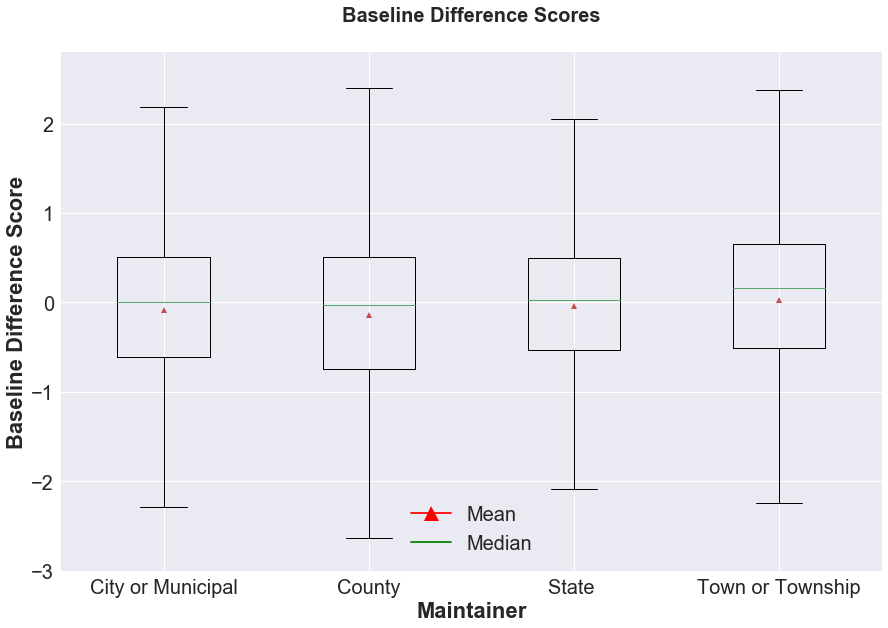

In [7]:
## Midwest, Northeast, South, West
scores_maint1 = maintainers[maintainers['maintainername'] == 'City or Municipal Highway Agency']['score']
scores_maint2 = maintainers[maintainers['maintainername'] == 'County Highway Agency']['score']
scores_maint3 = maintainers[maintainers['maintainername'] == 'State Highway Agency']['score']
scores_maint4 = maintainers[maintainers['maintainername'] == 'Town or Township Highway Agency']['score']

scores_maint = [scores_maint1,scores_maint2,scores_maint3,scores_maint4]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')

# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_maint, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("Maintainer", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

#### ANOVA - Small Sample

In [8]:
maintainers = df_anova[df_anova['maintainer'].isin([1,2,3,4])]
agency = {
         1 : "State Highway Agency",
         2 : "County Highway Agency",
         3 : "Town or Township Highway Agency",
         4 : "City or Municipal Highway Agency"
         }
maintainers['maintainername'] = maintainers['maintainer'].map(agency)
maint = maintainers.groupby('maintainername').apply(lambda s: s.sample(100))['maintainername'].tolist()
score = maintainers.groupby('maintainername').apply(lambda s: s.sample(100))['score'].tolist()
df_maint_sample_100 = pd.DataFrame({'maintainername':maint, 'score':score})

formula = 'score ~ C(maintainername)'
maint_undersample = undersample(df_maint_sample_100, 'maintainername')
aov(maint_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(maintainername),4.962376,3.0,1.873941,0.133393,0.013998,0.006512
Residual,349.548623,396.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [9]:
formula = 'score ~ C(maintainername)'
maint_undersample = undersample(maintainers, 'maintainername')
aov(maint_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(maintainername),577.079242,3.0,245.509722,5.460763e-159,0.004212,0.004195
Residual,136421.928827,174116.0,NaN,NaN,NaN,NaN
